In [1]:
import six.moves
import itertools

from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
from statsmodels.tsa.statespace.sarimax import SARIMAX

def arima_process(size, ar_coefs, ma_coefs, d=0):
    """Simulate a series from an arima model."""
    arma = ArmaProcess(ar_coefs, ma_coefs)
    arma_series = arma.generate_sample(size + d)
    # Integrate d times.
    for i in six.moves.range(d):
        arma_series = np.cumsum(arma_series)
    return pd.Series(arma_series)

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def plot_arima_process(ax, size, ar_coefs, ma_coefs, d=0):
    series = arima_process(size, ar_coefs, ma_coefs, d)
    ax.plot(series.index, series)

In [3]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

In [4]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

In [5]:
def plot_series_and_first_differences(class_1_count_posts_by_date):
    fig, axs = plt.subplots(2, figsize=(14, 4))
    plot_series_and_difference(axs, class_1_count_posts_by_date, "class_1_posts_per_day")
    plt.tight_layout()

In [6]:
posts_df = pd.read_csv('../data/posts.csv')

In [7]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4584013 entries, 0 to 4584012
Data columns (total 5 columns):
id                   int64
date                 object
classroom_id         int64
picture_file_name    object
private              object
dtypes: int64(2), object(3)
memory usage: 174.9+ MB


In [8]:
# np.array([count_posts_per_day_df.index])
# count_posts_per_day_df.index.get_level_values(0).unique()

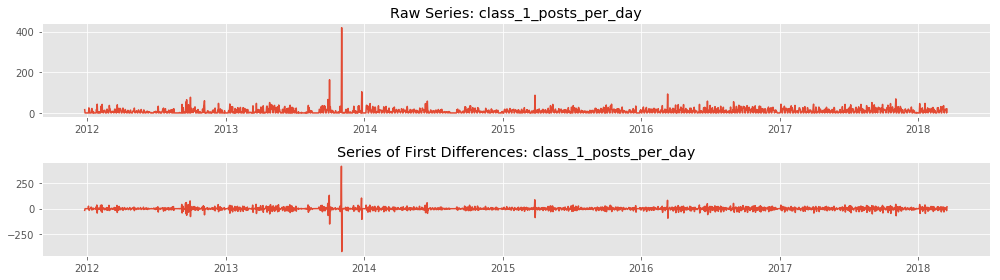

In [9]:
posts_df['date'] = pd.to_datetime(posts_df['date'], errors='coerce')
count_posts_per_day_df = posts_df.groupby(['classroom_id', 'date']).count()
class_1_count_posts_by_date = pd.Series(count_posts_per_day_df.loc[1]['id'].values, 
                            count_posts_per_day_df.loc[1].index)
class_1_count_posts_by_date = class_1_count_posts_by_date.astype('float64')
class_1_count_posts_by_date = class_1_count_posts_by_date.reindex(pd.date_range(min(class_1_count_posts_by_date.index), max(class_1_count_posts_by_date.index), freq='D'), fill_value=0)
plot_series_and_first_differences(class_1_count_posts_by_date) 

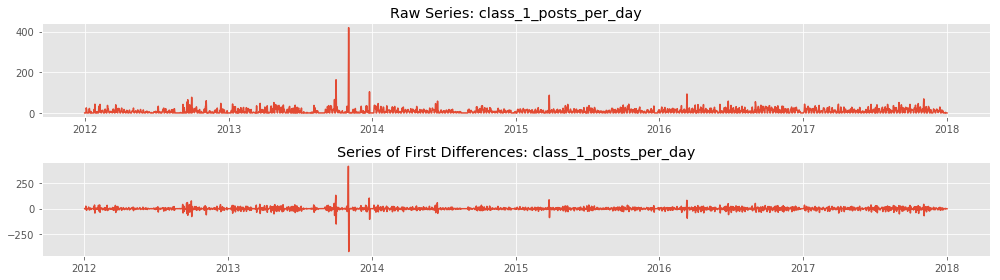

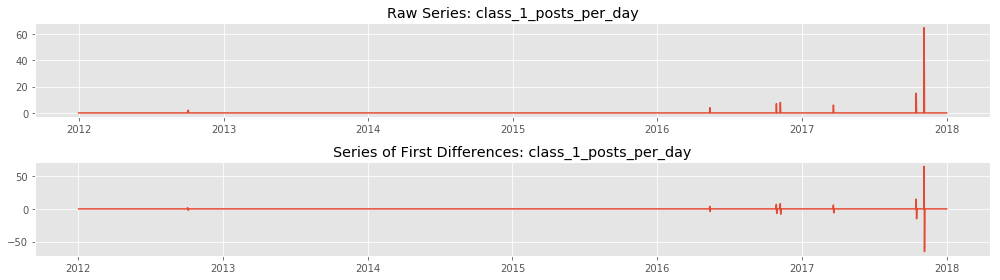

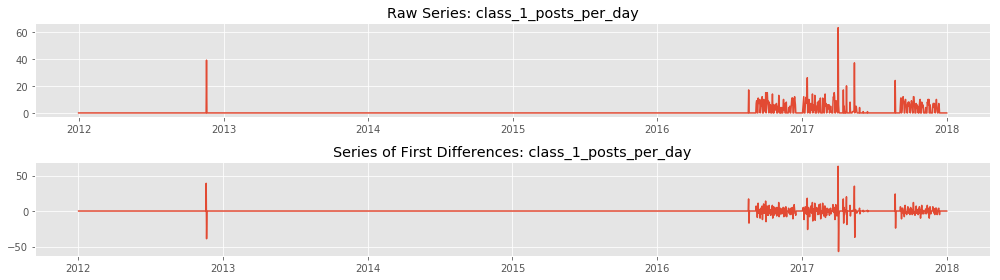

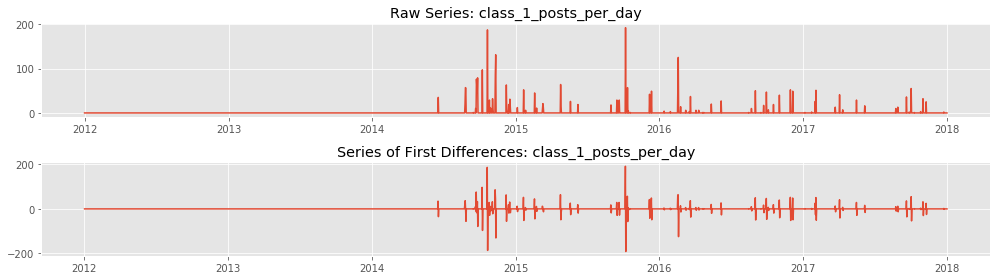

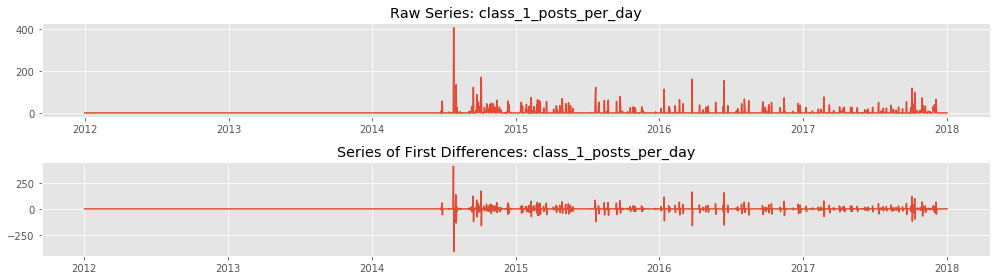

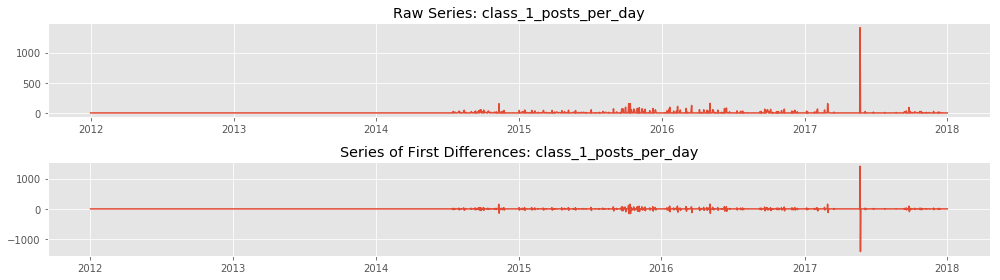

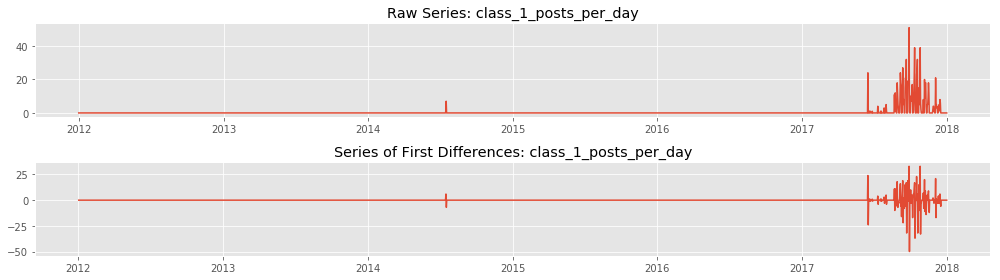

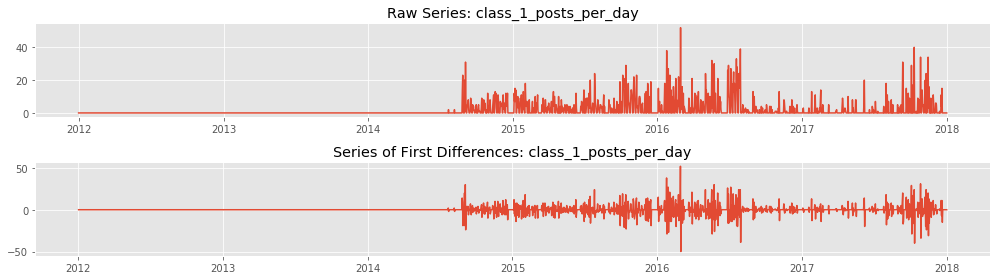

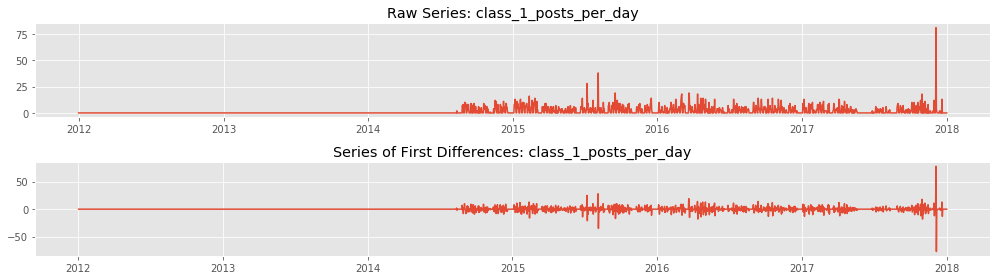

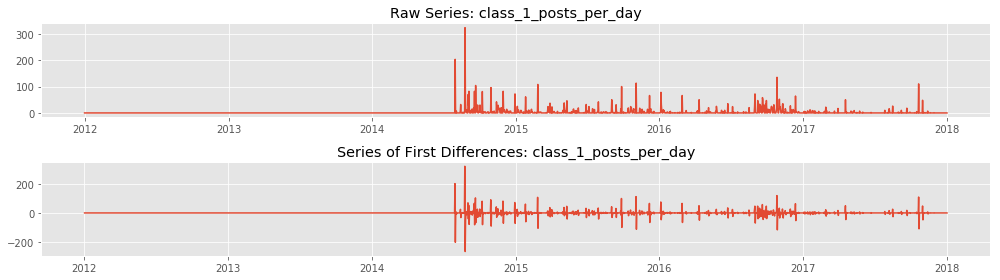

In [10]:
def plot_classroom_posts(posts_df, num):
    posts_df['date'] = pd.to_datetime(posts_df['date'], errors='coerce')
    count_posts_per_day_df = posts_df.groupby(['classroom_id', 'date']).count()
#     min_date, max_date = min(posts_df['date']), max(posts_df['date'])
    min_date, max_date = pd.to_datetime("2012"), pd.to_datetime("2018")
    for i in count_posts_per_day_df.index.get_level_values(0).unique()[:num]:
#         i=1
        class_1_count_posts_by_date = pd.Series(count_posts_per_day_df.loc[i]['id'].values, 
                                    count_posts_per_day_df.loc[i].index)
        class_1_count_posts_by_date = class_1_count_posts_by_date.astype('float64')
        class_1_count_posts_by_date = class_1_count_posts_by_date.reindex(pd.date_range(min_date, max_date, freq='D'), fill_value=0)
        if len(class_1_count_posts_by_date)>3:
            plot_series_and_first_differences(class_1_count_posts_by_date) 
            plt.show()
    return None
plot_classroom_posts(posts_df, 10)

In [11]:
class_1_posts_diff = class_1_count_posts_by_date.diff()[1:]

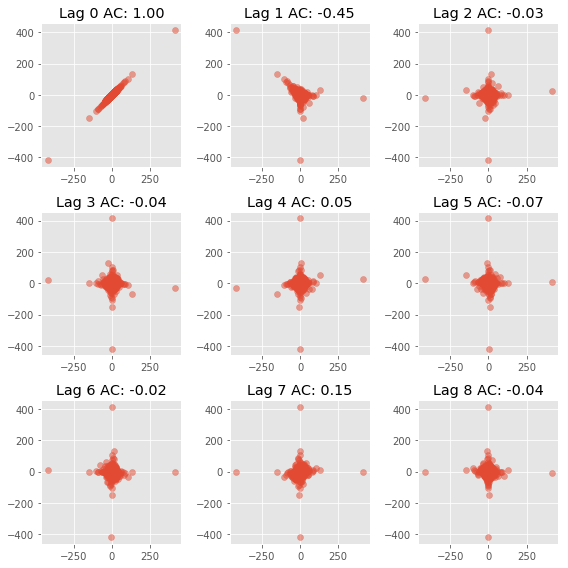

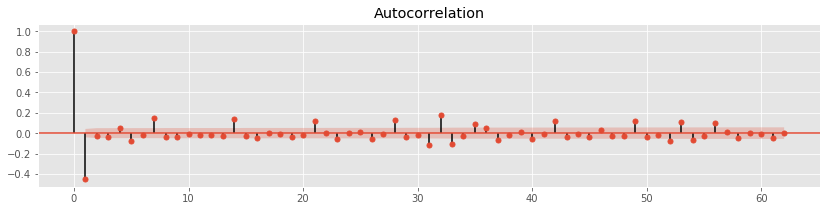

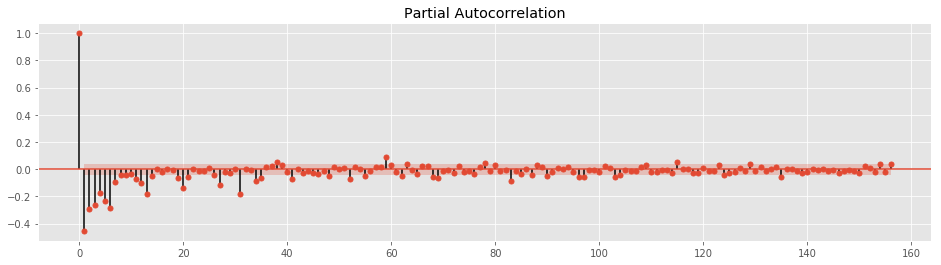

In [12]:
def plot_correlations(class_1_posts_diff):
    # 1
    plot_lag_correlation(class_1_count_posts_by_date)
    # 2
    fig, ax = plt.subplots(1, figsize=(14, 3))
    _ = sm.graphics.tsa.plot_acf(class_1_posts_diff, lags=62, ax=ax)
    # 3
    fig, ax = plt.subplots(1, figsize=(16, 4))
    _ = sm.graphics.tsa.plot_pacf(class_1_posts_diff, lags=3*52, ax=ax)
    return None

def plot_lag_correlation(class_1_count_posts_by_date):
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axs.flatten()):
        series, lagged = series_and_lagged(class_1_posts_diff, lag=i)
        autocorr = compute_autocorrelation(class_1_posts_diff, lag=i)
        ax.scatter(series, lagged, alpha=0.5)
        ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    plt.tight_layout()

def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))
plot_correlations(class_1_posts_diff)

In [13]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [14]:
model_class_1_posts_by_day = ARIMA(class_1_count_posts_by_date, order=(3, 1, 0)).fit()
print("ARIMA(3, 1, 0) coefficients from Electric model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    model_class_1_posts_by_day.params[0], 
        format_list_of_floats(list(model_class_1_posts_by_day.params[1:]))
    ))

ARIMA(3, 1, 0) coefficients from Electric model:
  Intercept 0.00
  AR ['-0.67', '-0.45', '-0.27']


In [15]:
 model_class_1_posts_by_day

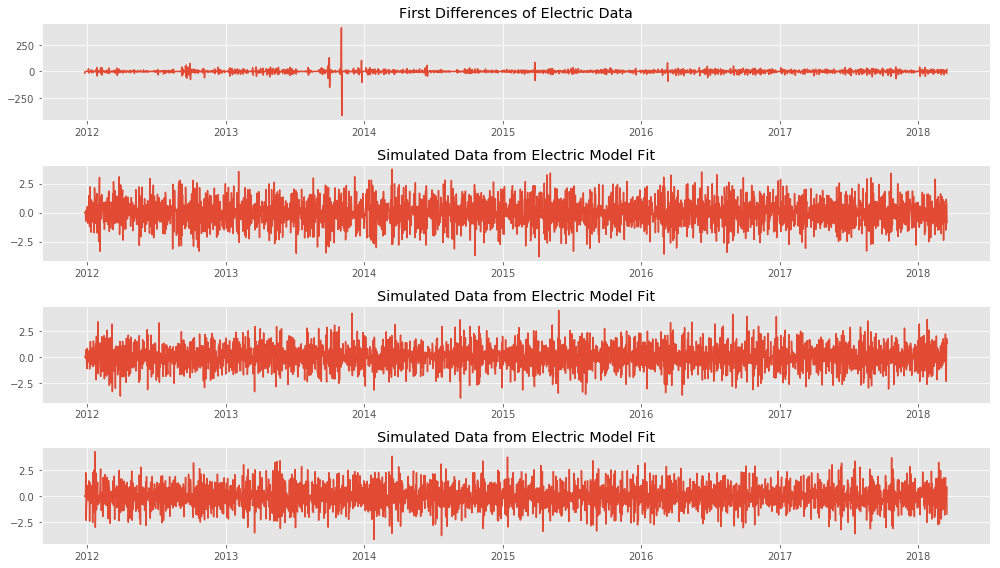

In [16]:
def sim_data(class_1_posts_diff):
    fig, ax = plt.subplots(4, figsize=(14, 8))
    ax[0].plot(class_1_posts_diff.index, class_1_posts_diff)
    ax[0].set_title("First Differences of Electric Data")
    for i in range(1, 4):
        simulated_data = auto_regressive_process(len(class_1_posts_diff), 
                                                 list(model_class_1_posts_by_day.params)[1:])
        simulated_data.index = class_1_posts_diff.index
        ax[i].plot(simulated_data.index, simulated_data)
        ax[i].set_title("Simulated Data from Electric Model Fit")
    plt.tight_layout()
    plt.show()
sim_data(class_1_posts_diff)

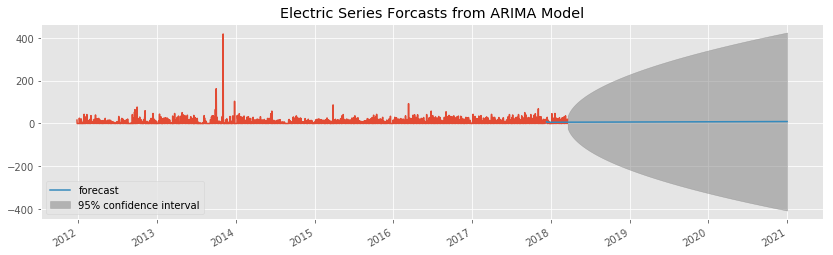

In [17]:
def plot_forecast_interval(model_class_1_posts_by_day, class_1_count_posts_by_date):
    fig, ax = plt.subplots(1, figsize=(14, 4))
    ax.plot(class_1_count_posts_by_date.index, class_1_count_posts_by_date)


    fig = model_class_1_posts_by_day.plot_predict('2017-12-11', '2020', 
                                      dynamic=True, ax=ax, plot_insample=False)

    _ = ax.legend().get_texts()[0].set_text("95% Prediction Interval")
    _ = ax.legend(loc="lower left")

    _ = ax.set_title("Electric Series Forcasts from ARIMA Model")
    plt.show
plot_forecast_interval(model_class_1_posts_by_day, class_1_count_posts_by_date)

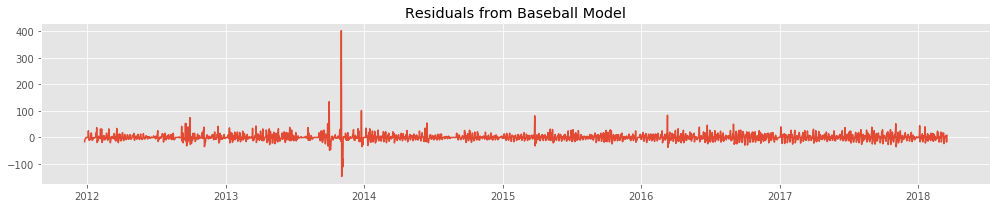

In [18]:
def make_model_residuals(model_class_1_posts_by_day):
    fig, ax = plt.subplots(1, figsize=(14, 3))
    ax.plot(model_class_1_posts_by_day.resid.index, model_class_1_posts_by_day.resid)
    ax.set_title("Residuals from Baseball Model")
    plt.tight_layout()
    return None
make_model_residuals(model_class_1_posts_by_day)

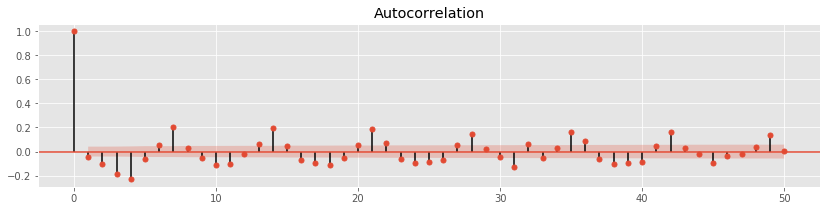

In [19]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(model_class_1_posts_by_day.resid, lags=50, ax=ax)

In [20]:
def try_arimas(class_1_count_posts_by_date):
    parameters = [
        {'AR': 3, 'MA': 0},
        {'AR': 2, 'MA': 0},
        {'AR': 4, 'MA': 0},
        {'AR': 3, 'MA': 1}
    ]

    models = {}
    for params in parameters:
        models[(params['AR'], params['MA'])] = ARIMA(class_1_count_posts_by_date, order=(params['AR'], 1, params['MA'])).fit()

    for model_params in models:
        print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))
try_arimas(class_1_count_posts_by_date)

ARIMA(3, 1, 0) AIC: 19035.99352210017
ARIMA(2, 1, 0) AIC: 19200.863258805875
ARIMA(4, 1, 0) AIC: 18969.600717592606
ARIMA(3, 1, 1) AIC: 18542.701308646898


In [21]:
seasonal_model_class_1_posts_by_day = SARIMAX(class_1_count_posts_by_date, order=(1, 1, 0), seasonal_order=(1, 0, 0, 52)).fit()
print("ARIMA(3, 1, 0) coefficients from Electric model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    seasonal_model_class_1_posts_by_day.params[0], 
        format_list_of_floats(list(model_class_1_posts_by_day.params[1:]))
    ))

ARIMA(3, 1, 0) coefficients from Electric model:
  Intercept -0.45
  AR ['-0.67', '-0.45', '-0.27']


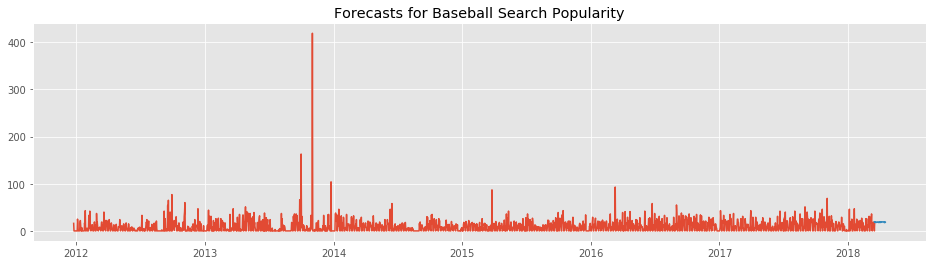

In [22]:
def plot_prediction(class_1_count_posts_by_date, seasonal_model_class_1_posts_by_day):
    fig, ax = plt.subplots(1, figsize=(16, 4))
    ax.plot(class_1_count_posts_by_date.index, class_1_count_posts_by_date)

    preds = seasonal_model_class_1_posts_by_day.predict('2018-03-17', '2018-04-17', 
                       dynamic=True, ax=ax, plot_insample=False)

    ax.plot(preds.index, preds)
    ax.set_title("Forecasts for Baseball Search Popularity")
plot_prediction(class_1_count_posts_by_date, seasonal_model_class_1_posts_by_day)

ARIMA(3, 1, 0) coefficients from Electric model:
  Intercept 0.00
  AR ['-0.67', '-0.45', '-0.27']


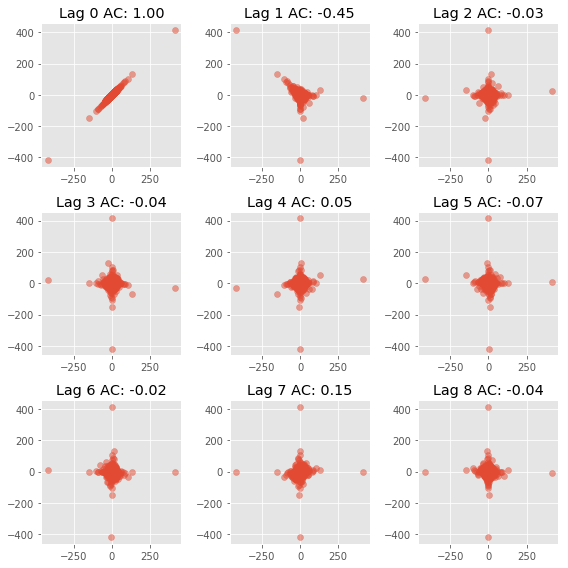

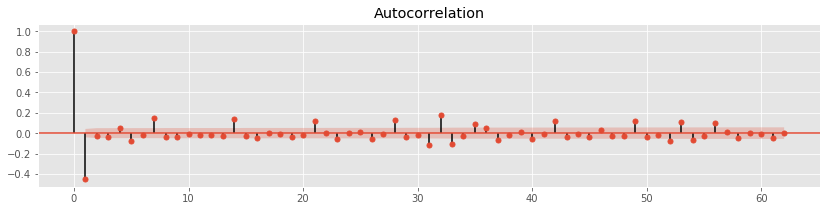

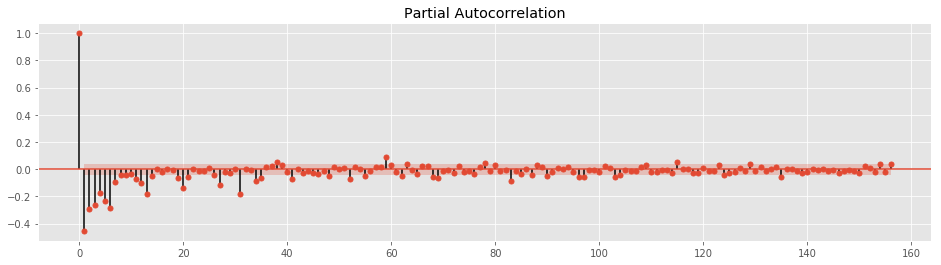

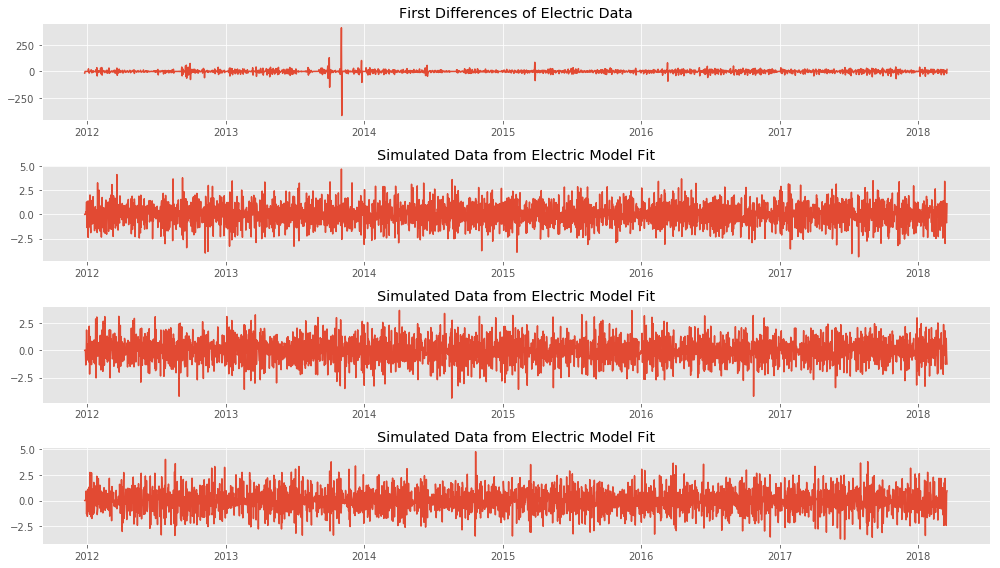

ARIMA(3, 1, 0) AIC: 19035.99352210017
ARIMA(2, 1, 0) AIC: 19200.863258805875
ARIMA(4, 1, 0) AIC: 18969.600717592606
ARIMA(3, 1, 1) AIC: 18542.701308646898
ARIMA(3, 1, 0) coefficients from Electric model:
  Intercept -0.45
  AR ['-0.67', '-0.45', '-0.27']


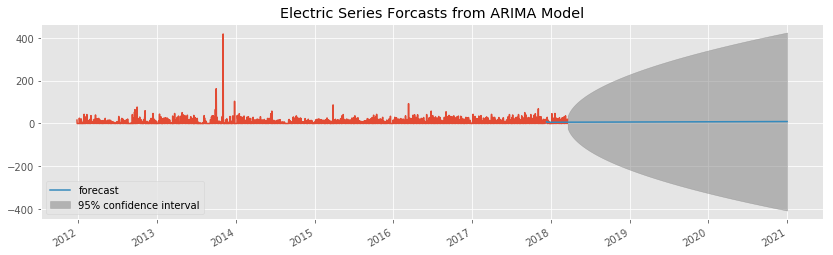

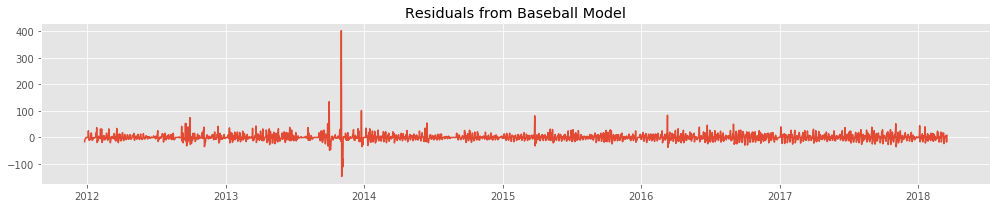

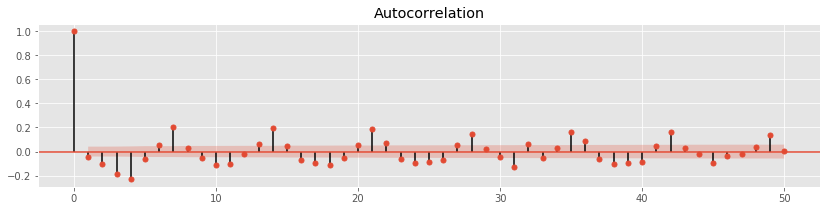

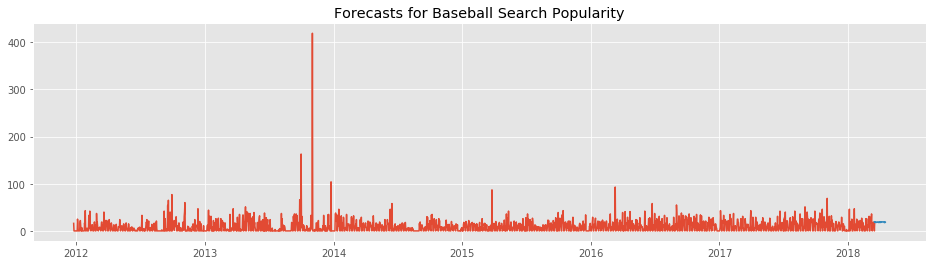

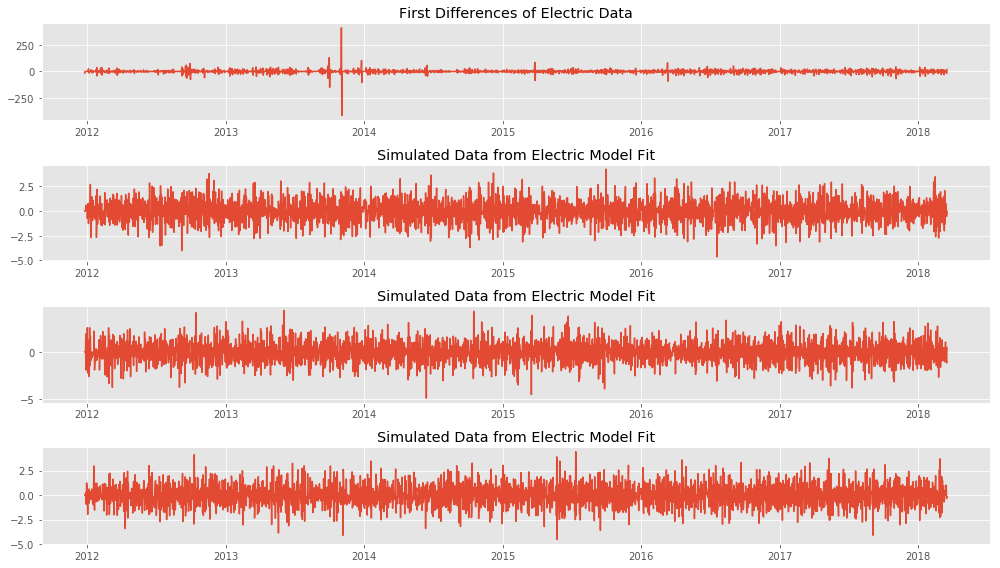

(<statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x11a5f5f60>,
 <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x11b2826a0>)

In [23]:
def make_arema_prediction(class_1_count_posts_by_date):
    class_1_posts_diff = class_1_count_posts_by_date.diff()[1:]
    plot_correlations(class_1_posts_diff)
    model_class_1_posts_by_day = ARIMA(class_1_count_posts_by_date, order=(3, 1, 0)).fit()
    print("ARIMA(3, 1, 0) coefficients from Electric model:\n  Intercept {0:2.2f}\n  AR {1}".format(
        model_class_1_posts_by_day.params[0], 
            format_list_of_floats(list(model_class_1_posts_by_day.params[1:]))
        ))
    sim_data(class_1_posts_diff)
    plot_forecast_interval(model_class_1_posts_by_day, class_1_count_posts_by_date)
    make_model_residuals(model_class_1_posts_by_day)
    fig, ax = plt.subplots(1, figsize=(14, 3))
    _ = sm.graphics.tsa.plot_acf(model_class_1_posts_by_day.resid, lags=50, ax=ax)
    try_arimas(class_1_count_posts_by_date)
    seasonal_model_class_1_posts_by_day = SARIMAX(class_1_count_posts_by_date, order=(1, 1, 0), seasonal_order=(1, 0, 0, 52)).fit()
    print("ARIMA(3, 1, 0) coefficients from Electric model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    seasonal_model_class_1_posts_by_day.params[0], 
        format_list_of_floats(list(model_class_1_posts_by_day.params[1:]))
    ))
    plot_prediction(class_1_count_posts_by_date, seasonal_model_class_1_posts_by_day)
    sim_data(class_1_posts_diff)
    return model_class_1_posts_by_day, seasonal_model_class_1_posts_by_day
make_arema_prediction(class_1_count_posts_by_date)

In [24]:
%history   0-99


import six.moves
import itertools

from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
from statsmodels.tsa.statespace.sarimax import SARIMAX

def arima_process(size, ar_coefs, ma_coefs, d=0):
    """Simulate a series from an arima model."""
    arma = ArmaProcess(ar_coefs, ma_coefs)
    arma_series = arma.generate_sample(size + d)
    # Integrate d times.
    for i in six.moves.range(d):
        arma_series = np.cumsum(arma_series)
    return pd.Series(arma_series)
def plot_arima_process(ax, size, ar_coefs, ma_coefs, d=0):
    series = arima_process(size, ar_coefs, ma_coefs, d)
    ax.plot(series.index, series)
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
   